<a href="https://colab.research.google.com/github/SatChittAnand/Seq2Seq-model-newspaper-text-summarization/blob/main/CNN-DailyMail%20News%20Text%20Summarize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
cnn_dailymail_path = kagglehub.dataset_download('gowrishankarp/newspaper-text-summarization-cnn-dailymail')

print('Data source import complete.')


Using Colab cache for faster access to the 'newspaper-text-summarization-cnn-dailymail' dataset.
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv


In [ ]:
# Load train, validation, and test splits
train_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv")
val_df   = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv")
test_df  = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Peek at the first few rows
train_df.head()


Train shape: (287113, 3)
Validation shape: (13368, 3)
Test shape: (11490, 3)


,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
# ==========================================
# 1. LOAD VALIDATION & TEST DATA
# ==========================================
# Load Validation Subset
val_csv_path = "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv"
val_df = pd.read_csv(val_csv_path).iloc[:500] # Use 500 samples for speed
print(f"Validation Data Loaded: {len(val_df)} samples")

# Load Test Subset (for final demo)
test_csv_path = "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv"
test_df = pd.read_csv(test_csv_path).iloc[:10] # Just for checking outputs
print(f"Test Data Loaded: {len(test_df)} samples")

# Create DataLoaders
val_dataset = CNNDataset(val_df, tokenizer, MAX_LEN_ART, MAX_LEN_SUM)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# ==========================================
# 2. EVALUATION FUNCTION
# ==========================================
def evaluate_model(model, iterator, criterion):
    model.eval() # Turn off dropout/batchnorm
    epoch_loss = 0
    correct_tokens = 0
    total_tokens = 0

    with torch.no_grad(): # No gradients needed for validation
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)

            # Turn off teacher forcing for validation/inference
            output = model(src, trg, teacher_forcing_ratio=0)

            # Flatten outputs and targets
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

            # Accuracy
            preds = output.argmax(1)
            mask = trg != PAD_IDX
            correct = (preds == trg) & mask
            correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

    return epoch_loss / len(iterator), correct_tokens / total_tokens if total_tokens > 0 else 0

Validation Data Loaded: 500 samples
Test Data Loaded: 10 samples


Starting Training Loop...

--- Training Model: NONE ---
Epoch: 01 | Time: 62.34s | Loss: 7.8368 | Acc: 0.0590
Epoch: 02 | Time: 60.82s | Loss: 7.2054 | Acc: 0.0730
Epoch: 03 | Time: 60.28s | Loss: 7.0496 | Acc: 0.0819
Epoch: 04 | Time: 60.80s | Loss: 6.8523 | Acc: 0.0874
Epoch: 05 | Time: 60.56s | Loss: 6.6057 | Acc: 0.0936
Total time for none: 304.81s

--- Training Model: BAHDANAU ---
Epoch: 01 | Time: 67.61s | Loss: 7.7953 | Acc: 0.0559
Epoch: 02 | Time: 67.85s | Loss: 7.3255 | Acc: 0.0651
Epoch: 03 | Time: 67.80s | Loss: 7.2337 | Acc: 0.0743
Epoch: 04 | Time: 67.73s | Loss: 7.1353 | Acc: 0.0791
Epoch: 05 | Time: 68.22s | Loss: 7.0166 | Acc: 0.0819
Total time for bahdanau: 339.21s

--- Training Model: LUONG ---
Epoch: 01 | Time: 64.09s | Loss: 7.7767 | Acc: 0.0558
Epoch: 02 | Time: 64.12s | Loss: 7.3206 | Acc: 0.0641
Epoch: 03 | Time: 64.44s | Loss: 7.2257 | Acc: 0.0740
Epoch: 04 | Time: 63.96s | Loss: 7.1191 | Acc: 0.0801
Epoch: 05 | Time: 64.08s | Loss: 6.9962 | Acc: 0.0830
Total t

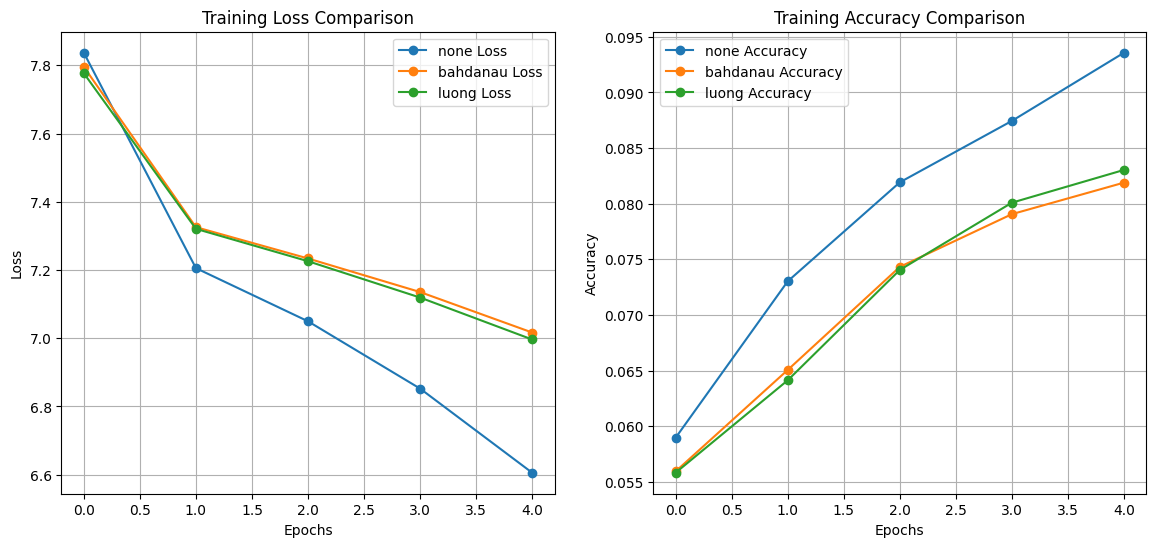

In [ ]:
# ==========================================
# 3. MODEL CLASSES (FIXED)
# ==========================================

# --- Encoder (Same as before, included for completeness) ---
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

# --- Attention Mechanisms (Same as before) ---
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, values):
        query = query.permute(1, 0, 2)
        score = self.V(torch.tanh(self.W1(query) + self.W2(values)))
        attention_weights = F.softmax(score, dim=1)
        context = torch.bmm(attention_weights.permute(0, 2, 1), values)
        return context, attention_weights

class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(LuongAttention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, query, values):
        query = query.permute(1, 0, 2)
        query_proj = self.W(query)
        score = torch.bmm(query_proj, values.permute(0, 2, 1))
        score = score.permute(0, 2, 1)
        attention_weights = F.softmax(score, dim=1)
        context = torch.bmm(attention_weights.permute(0, 2, 1), values)
        return context, attention_weights

# --- Decoder (FIXED LOGIC HERE) ---
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, attention_type=None):
        super(Decoder, self).__init__()
        self.attention_type = attention_type
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        # FIX: Explicit boolean flag for attention usage
        self.use_attention = attention_type in ['bahdanau', 'luong']

        self.embedding = nn.Embedding(output_dim, embed_dim)

        # FIX: Use the boolean flag to determine input size
        # If attention: input = embedding + context (hidden_dim)
        # If no attention: input = embedding
        gru_input_dim = embed_dim + (hidden_dim if self.use_attention else 0)

        self.gru = nn.GRU(gru_input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        if self.attention_type == 'bahdanau':
            self.attn = BahdanauAttention(hidden_dim)
        elif self.attention_type == 'luong':
            self.attn = LuongAttention(hidden_dim)
        else:
            self.attn = None

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)

        if self.use_attention:
            context, _ = self.attn(hidden, encoder_outputs)
            rnn_input = torch.cat((embedded, context), dim=2)
        else:
            rnn_input = embedded

        output, hidden = self.gru(rnn_input, hidden)
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden

# --- Seq2Seq Wrapper (Same as before) ---
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

# ==========================================
# 5. EXECUTION & COMPARISON (RE-RUN THIS)
# ==========================================

models_to_run = ['none', 'bahdanau', 'luong']
history = {}

print("Starting Training Loop...")

for mode in models_to_run:
    print(f"\n--- Training Model: {mode.upper()} ---")

    # Init Models with corrected Class
    enc = Encoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
    dec = Decoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, attention_type=mode)
    model = Seq2Seq(enc, dec, device).to(device)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    losses = []
    accs = []

    start_total = time.time()

    for epoch in range(EPOCHS):
        st = time.time()
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, clip=1.0)
        et = time.time()

        losses.append(train_loss)
        accs.append(train_acc)

        print(f'Epoch: {epoch+1:02} | Time: {et-st:.2f}s | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')

    history[mode] = {'loss': losses, 'accuracy': accs}
    print(f"Total time for {mode}: {time.time()-start_total:.2f}s")

# ==========================================
# 6. PLOTTING
# ==========================================
print("\nGenerating Plots...")

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
for mode in models_to_run:
    plt.plot(history[mode]['loss'], label=f'{mode} Loss', marker='o')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
for mode in models_to_run:
    plt.plot(history[mode]['accuracy'], label=f'{mode} Accuracy', marker='o')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

Starting Training with Validation...

--- Training Model: NONE ---
Epoch: 01 | Time: 108.25s | Train Loss: 7.8664 | Val Loss: 7.5127 | Val Acc: 0.0602
Epoch: 02 | Time: 80.54s | Train Loss: 7.2047 | Val Loss: 7.5424 | Val Acc: 0.0548
Epoch: 03 | Time: 76.68s | Train Loss: 7.0630 | Val Loss: 7.5879 | Val Acc: 0.0474
Epoch: 04 | Time: 71.76s | Train Loss: 6.9017 | Val Loss: 7.6711 | Val Acc: 0.0412
Epoch: 05 | Time: 71.80s | Train Loss: 6.6839 | Val Loss: 7.6777 | Val Acc: 0.0442

--- Training Model: BAHDANAU ---
Epoch: 01 | Time: 79.82s | Train Loss: 7.7991 | Val Loss: 7.5468 | Val Acc: 0.0547
Epoch: 02 | Time: 80.47s | Train Loss: 7.3249 | Val Loss: 7.5753 | Val Acc: 0.0623
Epoch: 03 | Time: 79.93s | Train Loss: 7.2469 | Val Loss: 7.5795 | Val Acc: 0.0567
Epoch: 04 | Time: 80.16s | Train Loss: 7.1404 | Val Loss: 7.5729 | Val Acc: 0.0588
Epoch: 05 | Time: 80.29s | Train Loss: 7.0143 | Val Loss: 7.5871 | Val Acc: 0.0563

--- Training Model: LUONG ---
Epoch: 01 | Time: 75.27s | Train Loss

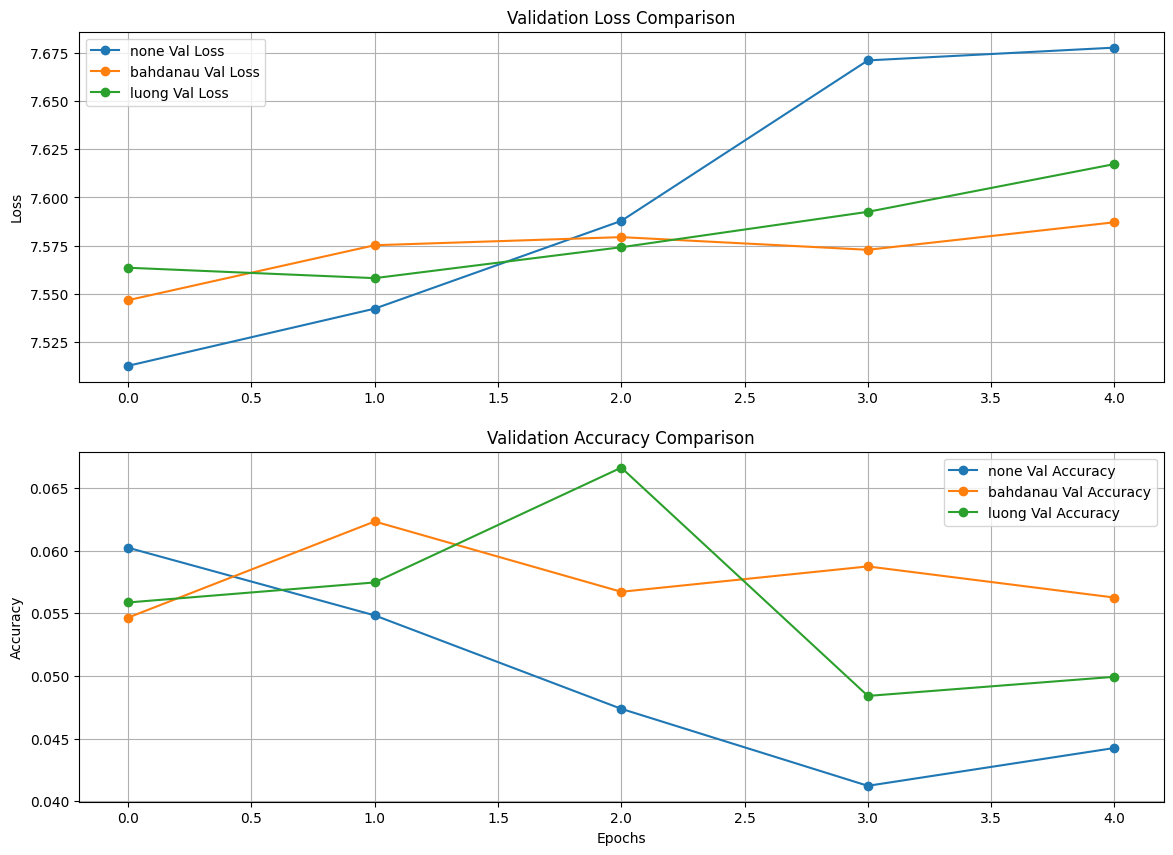

In [ ]:
# ==========================================
# 3. TRAINING WITH VALIDATION
# ==========================================

models_to_run = ['none', 'bahdanau', 'luong']
# Store full history
history = {m: {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []} for m in models_to_run}
trained_models = {} # Store models for testing later

print("Starting Training with Validation...")

for mode in models_to_run:
    print(f"\n--- Training Model: {mode.upper()} ---")

    # Re-init Model (Ensure you run the Class definitions from previous turn first!)
    enc = Encoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM)
    dec = Decoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, attention_type=mode)
    model = Seq2Seq(enc, dec, device).to(device)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    for epoch in range(EPOCHS):
        st = time.time()

        # Train
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, clip=1.0)

        # Validate
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        et = time.time()

        # Store
        history[mode]['train_loss'].append(train_loss)
        history[mode]['train_acc'].append(train_acc)
        history[mode]['val_loss'].append(val_loss)
        history[mode]['val_acc'].append(val_acc)

        print(f'Epoch: {epoch+1:02} | Time: {et-st:.2f}s | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    trained_models[mode] = model # Save for testing step

# ==========================================
# 4. PLOTTING VALIDATION RESULTS
# ==========================================
plt.figure(figsize=(14, 10))

# Plot Validation Loss
plt.subplot(2, 1, 1)
for mode in models_to_run:
    plt.plot(history[mode]['val_loss'], label=f'{mode} Val Loss', marker='o')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(2, 1, 2)
for mode in models_to_run:
    plt.plot(history[mode]['val_acc'], label=f'{mode} Val Accuracy', marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# ==========================================
# 5. TESTING / INFERENCE
# ==========================================

def generate_summary(model, tokenizer, article, max_len=60, device='cpu'):
    model.eval()

    # Tokenize Input
    tokens = tokenizer.encode(article, add_special_tokens=True, truncation=True, max_length=MAX_LEN_ART)
    src = torch.LongTensor(tokens).unsqueeze(0).to(device) # [1, src_len]

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src)

        # Start token
        trg_indexes = [tokenizer.cls_token_id]

        for i in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

            # Greedy prediction (Top 1)
            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)

            if pred_token == tokenizer.sep_token_id:
                break

    # Detokenize
    summary = tokenizer.decode(trg_indexes, skip_special_tokens=True)
    return summary

# --- Run Test on 3 Random Samples ---
print("\n=== GENERATING SUMMARIES ON TEST DATA ===")

# Pick 3 random indices from test_df
indices = [0, 1, 2]

for idx in indices:
    article = test_df.iloc[idx]['article']
    actual_summary = test_df.iloc[idx]['highlights']

    print(f"\nExample {idx+1}")
    print("-" * 50)
    print(f"Original Article (truncated): {article[:300]}...")
    print(f"Actual Summary: {actual_summary}")
    print("-" * 50)

    for mode in models_to_run:
        generated = generate_summary(trained_models[mode], tokenizer, article, device=device)
        print(f"[{mode.upper()}] Generated: {generated}")


=== GENERATING SUMMARIES ON TEST DATA ===

Example 1
--------------------------------------------------
Original Article (truncated): Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's ...
Actual Summary: Experts question if  packed out planes are putting passengers at risk .
U.S consumer advisory group says minimum space must be stipulated .
Safety tests conducted on planes with more leg room than airlines offer .
--------------------------------------------------
[NONE] Generated: the of the, of the, of the........................ the.. the.. the the........ the the.. the the...
[BAHDANAU] Generated: the : of the of the of the.................................................
[LUONG] Generated: new :,,,,,,,,,,,,,,,,,,,,,,,,,...............